In [2]:
# Загружаем датасет рукописных английских букв emnist
# Каждая буква представлена в формате картинки 28х28 пикселей
import kagglehub

path = kagglehub.dataset_download("crawford/emnist")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\fdsaf\.cache\kagglehub\datasets\crawford\emnist\versions\3


In [3]:
# Необходимо взять emnist-letters-test.csv и emnist-letters-train.csv
# Каждая строка в таблице - отдельная картинка
# 785 (28 x 28) столбцов, каждый столбец = величина пикселя 
# Первый столбец — это метка класса (какая это буква). Подробнее в mappings.txt
import pandas as pd # для обработки данных
testing_letter = pd.read_csv(path + '/emnist-letters-test.csv')
training_letter = pd.read_csv(path + '/emnist-letters-train.csv')

print(training_letter.shape) # 88799 = количество элементов для обучения
print(testing_letter.shape) # 14799 = кол-во элементов для тестирования

(88799, 785)
(14799, 785)


(88799,)
(88799, 784)


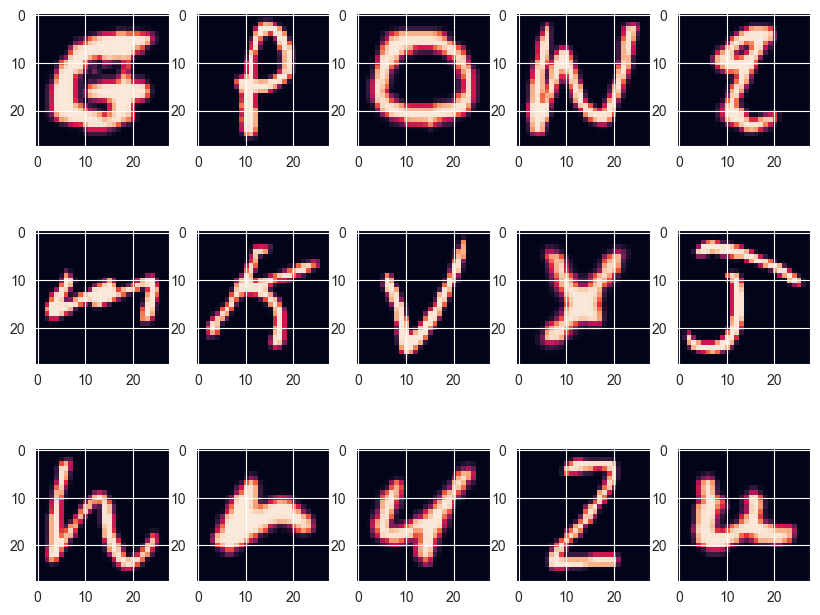

In [4]:
import numpy as np # для линейной алгебры
# training_letter
y1 = np.array(training_letter.iloc[:,0].values) # Берём первый столбец всех строк (метка класса)
x1 = np.array(training_letter.iloc[:,1:].values) # Все строки, все столбцы кроме первого столбца
# testing_letter
y2 = np.array(testing_letter.iloc[:,0].values)
x2 = np.array(testing_letter.iloc[:,1:].values)
print(y1.shape) # метки для обучающей выборки
print(x1.shape) # признаки обучающей выборки


# Проверка картинок
import matplotlib.pyplot as plt # для создания графиков
fig,axes = plt.subplots(3,5,figsize=(10,8)) # создаёт сетку 3х5 из графиков, каждая клетка размером 10х8
for i,ax in enumerate(axes.flat): # индекс, объект оси
    ax.imshow(x1[i].reshape([28,28]).T) # отображает изображение, нужно транспонировать

In [5]:
# Перед тем, как подавать в данные в модель, мы нормализуем и изменим предоставленные нам данные. Это уменьшит сложность моделей и сделает модель эффективно работать, так как для обработки будут менее сложные числа.

# Приводим данные к диапазону [0,1]
train_images = x1 / 255.0
test_images = x2 / 255.0

train_images_number = train_images.shape[0] # кол-во изображений в обучающей выборке
train_images_height = 28
train_images_width = 28
train_images_size = train_images_height*train_images_width

train_images = train_images.reshape(train_images_number, train_images_height, train_images_width, 1)
# кол-во изображений, высота, ширина, 1 = кол-во каналов (1 т.к. чёрно белое)

test_images_number = test_images.shape[0]
test_images_height = 28
test_images_width = 28
test_images_size = test_images_height*test_images_width

test_images = test_images.reshape(test_images_number, test_images_height, test_images_width, 1)

In [6]:
import tensorflow as tf

# Количество классов (26 букв английского алфавита + спец символы)
number_of_classes = 37

# Преобразует метки классов в one-hot encoding.
# Например Если y1[i] = 2, то one-hot encoding будет [0, 0, 1, 0, ..., 0] 
# (длина вектора равна number_of_classes).
y1 = tf.keras.utils.to_categorical(y1, number_of_classes)
y2 = tf.keras.utils.to_categorical(y2, number_of_classes)

In [8]:
# Функция из библиотеки scikit-learn, которая разделяет данные на обучающую и тестовую выборки.
from sklearn.model_selection import train_test_split

# Делим данные на две части: обучающая выборка (80% данных), валидационная выборка (20% данных). 
# Фиксируем случайное разбиение для воспроизводимости результатов (random_state = 42)
train_x,test_x,train_y,test_y = train_test_split(train_images,y1,test_size=0.2,random_state = 42)

# Создание сверточной НС. Эта модель является FFNN, так как она соответствует определению сети прямого распространения.
# 1. Сверточный слой (Conv2D): 32 фильтра размером 3x3. Размер входных данных (28x28 пикселей, 1 канал)
# 2. Слой подвыборки (MaxPooling2D): Уменьшает размерность данных, выбирая макс значение в окне 2x2
# 3. Слой выравнивания (Flatten): Преобразует двумерные данные в одномерный вектор.
# 4. Полносвязные слои (Dense): Слой с 512 и 128 нейронами и функцией активации ReLU.
# 5. Выходной слой (Dense): Слой с количеством нейронов, равным числу классов (37), и функцией активации softmax

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,3,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(number_of_classes,activation='softmax')
])

# Модель настраивается для обучения.
# optimizer='rmsprop': Используется оптимизатор RMSprop для обновления весов модели.
# loss='categorical_crossentropy': Функция потерь для многоклассовой классификации
# metrics=['accuracy']: Метрика, которая будет отслеживаться во время обучения (точность).
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

C:\Users\fdsaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\fdsaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# EarlyStopping, ReduceLROnPlateau, ModelCheckpoint:
# Это callback-функции, которые используются для улучшения процесса обучения модели.
# EarlyStopping: Останавливает обучение, если метрика (например, точность) перестает улучшаться.
# ReduceLROnPlateau: Уменьшает скорость обучения, если метрика перестает улучшаться.
# ModelCheckpoint: Сохраняет лучшую версию модели во время обучения.

MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

# объект, который содержит информацию о процессе обучения (например, значения потерь и точности на каждой эпохе).
history = model.fit(train_x,train_y,epochs=10,validation_data=(test_x,test_y),callbacks=[MCP,ES,RLP])

Epoch 1/10
2217/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7319 - loss: 0.8901
Epoch 1: val_accuracy improved from -inf to 0.89116, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7321 - loss: 0.8895 - val_accuracy: 0.8912 - val_loss: 0.3303 - learning_rate: 0.0010
Epoch 2/10
2216/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9080 - loss: 0.2768
Epoch 2: val_accuracy improved from 0.89116 to 0.90090, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9080 - loss: 0.2768 - val_accuracy: 0.9009 - val_loss: 0.3087 - learning_rate: 0.0010
Epoch 3/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9319 - loss: 0.1997
Epoch 3: val_accuracy did not improve from 0.90090
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9319 - loss: 0.1997 - val_accuracy: 0.8977 - val_loss: 0.3499 - learning_rate: 0.0010
Epoch 4/10
2215/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9455 - loss: 0.1543
Epoch 4: val_accuracy improved from 0.90090 to 0.90242, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9455 - loss: 0.1544 - val_accuracy: 0.9024 - val_loss: 0.3670 - learning_rate: 0.0010
Epoch 5/10
2216/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9540 - loss: 0.1312
Epoch 5: val_accuracy did not improve from 0.90242
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9540 - loss: 0.1312 - val_accuracy: 0.8999 - val_loss: 0.3676 - learning_rate: 0.0010
Epoch 6/10
2218/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9715 - loss: 0.0728
Epoch 6: val_accuracy improved from 0.90242 to 0.91734, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9715 - loss: 0.0728 - val_accuracy: 0.9173 - val_loss: 0.3511 - learning_rate: 2.0000e-04
Epoch 7/10
2217/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9790 - loss: 0.0509
Epoch 7: val_accuracy improved from 0.91734 to 0.91943, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9790 - loss: 0.0509 - val_accuracy: 0.9194 - val_loss: 0.3765 - learning_rate: 2.0000e-04
Epoch 8/10
2219/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9804 - loss: 0.0475
Epoch 8: val_accuracy did not improve from 0.91943
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9804 - loss: 0.0475 - val_accuracy: 0.9193 - val_loss: 0.4018 - learning_rate: 2.0000e-04
Epoch 9/10
2218/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9837 - loss: 0.0396
Epoch 9: val_accuracy did not improve from 0.91943
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9837 - loss: 0.0396 - val_accuracy: 0.9169 - val_loss: 0.4270 - learning_rate: 1.0000e-04
Epoch 10/10
2218/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9839 - loss: 0.0374
Epoch 10: val_accuracy did not improve from 0.91943
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9839 - loss: 0.0374 - val_accuracy: 0.9185 - val_loss: 0.4296 - learning_ra

Text(0, 0.5, 'Accuray')

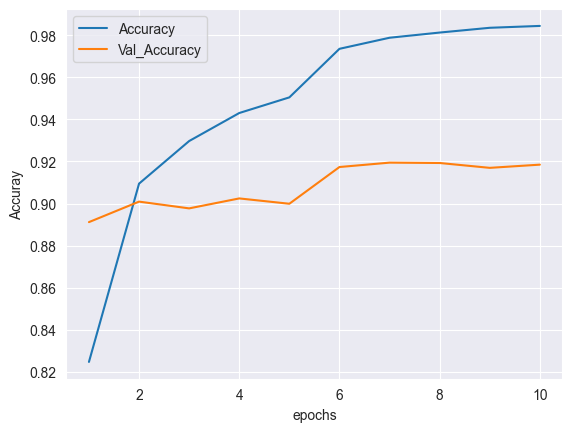

In [14]:
# для создания статистических графиков.
import seaborn as sns

# Получаем количество эпох, на которых обучалась модель
# history.history['accuracy'] содержит значения точности на обучающих данных для каждой эпохи
q = len(history.history['accuracy'])

# Устанавливаем размер графика (10x10 дюймов)
plt.figsize=(10,10)

# Строим график точности на обучающих данных (accuracy)
# x = range(1, 1+q): ось X — это номера эпох (начиная с 1)
# y = history.history['accuracy']: ось Y — значения точности на обучающих данных
# label='Accuracy': подпись для графика
sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuray')